In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.GAN_utils import loadBigGAN, BigGAN_wrapper
from core.utils.GAN_invert_utils import *
from core.utils.GAN_utils import upconvGAN
from pytorch_pretrained_biggan import truncated_noise_sample
import numpy as np
import torch
#%% 


In [11]:
# Set parameters
to_load_img = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\gan_invertion\real_monkeys\orginal"

center_croed = r"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\gan_invertion\real_monkeys\orginal_center_crop"
os.makedirs(center_croed, exist_ok=True)
refimgnms, refimgtsr = load_ref_imgs(
        imgdir=to_load_img, preprocess_type='center_crop', image_size=256)
for imgid in range(len(refimgnms)):
    img = ToPILImage()(refimgtsr[imgid])
    file_name = refimgnms[imgid].split('.')[0]
    image_format = "png"
    img.save(join(center_croed, f"{file_name}.{image_format}"))

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

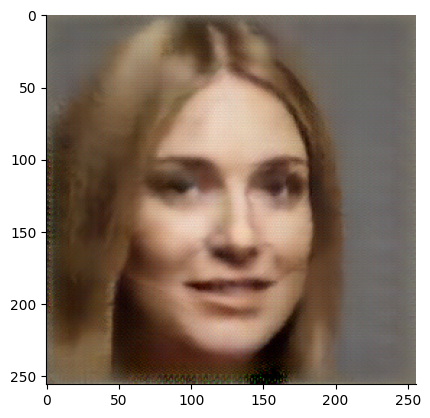

In [4]:
gan_name = 'fc6' # 'BigGAN' or 'fc6'
save_dir = rf"C:\Users\Alireza\OneDrive - Harvard University\Documents\coisne_results\gan_invertion\real_monkeys\inverted_{gan_name}_GAN_invert_with_scheduler"
os.makedirs(save_dir, exist_ok=True)
if gan_name == 'BigGAN':
    BGAN = loadBigGAN()
    G = BigGAN_wrapper(BGAN)
    code_length = 256
    fixnoise = 0.7 * truncated_noise_sample(1, 128, seed=1)
    init_code = np.concatenate((fixnoise, np.zeros((1, 128))), axis=1)
    # convert to tensor
    init_code = torch.tensor(init_code).float().cuda()
elif gan_name == 'fc6':

        G = upconvGAN('fc6').cuda().eval()
refimgnms, refimgtsr = load_ref_imgs(
        imgdir=center_croed, preprocess_type='center_crop', image_size=256)
for imgid in range(len(refimgnms)):
        targnm, target_imgtsr_real = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

        target_img = target_imgtsr_real[0]
        if gan_name == 'fc6':
                z_opts, img_opts= GAN_invert(G, target_img.cuda(), max_iter=int(5E5),
                                        print_progress=False)
        elif gan_name == 'BigGAN':

                z_opts, img_opts = GAN_invert(G, target_img.cuda(), z_init=init_code, max_iter=int(5E3),
                                        print_progress=False, batch_size = 1)
        else:
                raise ValueError('gan_name should be "BigGAN" or "fc6"')
        #imgs = resize_and_pad_tsr(img_opts, (147, 147), (40, 40))
        imgs = img_opts
        plt.imshow(ToPILImage()(imgs[0]))
        file_name = refimgnms[imgid].partition(".")[0]
        image_format = "png"
        img = ToPILImage()(imgs[0])
        img.save(join(save_dir, f"{file_name}.{image_format}"))
        # let save the z_opt
        z_opt = z_opts[0]
        z_opt = z_opt.cpu().detach().numpy()
        np.save(join(save_dir, f"{file_name}_z_opt.npy"), z_opt)


In [43]:
# I wabt repeat the refimgtsr for k time and concatenate them to make a batch of images

refimgtsr_inflated = torch.cat([refimgtsr for _ in range(5)], dim=0)

In [44]:
z_opts, img_opts= GAN_invert(G, refimgtsr_inflated.cuda(), max_iter=int(5E2),
                                        print_progress=False, batch_size = refimgtsr_inflated.shape[0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
refimgtsr_inflated.shape

torch.Size([60, 3, 256, 256])

In [12]:
# let mess up with the code 
# load the code first
#%%


# get all the z_opt
z_opt_dir = save_dir
z_opt_files = os.listdir(z_opt_dir)
z_opts = []
z_opt_files_name = []
for z_opt_file in z_opt_files:
    if z_opt_file.endswith(".npy"):
        z_opt = np.load(join(z_opt_dir, z_opt_file))
        z_opts.append(z_opt)
        z_opt_files_name.append(z_opt_file)

In [11]:


# now let make 10 difrent code from each code.
# this is the way you make it. first extract the direction unit vector of the code
# second find the norm of the code vector divided by 10 
# then make 10 difrent code by adding the i*norm to the zero code
# then make 10 more code by adding the i*norm to the first code
# the make 10 more code by same norm but in 10 difrent direction
k = 10
for z_code, z_opt_file in zip(z_opts, z_opt_files_name):
    # new set of code
    new_codes = []
    new_code_names = []
    # append the orginal code
    new_codes.append(z_code)
    new_code_names.append("orginal")

    z_code_norm = np.linalg.norm(z_code)
    z_code_dir = z_code/z_code_norm
    z_code_norm_step = z_code_norm/k

    # move in the direction of the code from zero
    for i in range(k):
        new_code = i*z_code_dir*z_code_norm_step
        new_codes.append(new_code)
        new_code_names.append(f"from_zero_{i}")
    # move in the direction of the code from first
    for i in range(k):
        new_code = z_code + i*z_code_dir*z_code_norm_step
        new_codes.append(new_code)
        new_code_names.append(f"from_first_{i}")
    # move rotate the code in k difrent direction 
    for i in range(k):
        # det a randon umit direction vector
        if gan_name == 'BigGAN':
            random_unit_direction = np.random.randn(1, 256)
        elif gan_name == 'fc6':
            random_unit_direction = np.random.randn(1, 4096)
        else:
            raise ValueError('gan_name should be "BigGAN" or "fc6"')
        random_unit_direction = random_unit_direction/np.linalg.norm(random_unit_direction)
        norm_step = z_code_norm/5
        new_code = z_code + (norm_step * random_unit_direction)
        new_codes.append(new_code)
        new_code_names.append(f"random_dir_{i}") 
    # let jump big step in the direction of the code
    for i in range(k):
        new_code = z_code + i*z_code_dir*z_code_norm_step*10
        new_codes.append(new_code)
        new_code_names.append(f"big_step_{i}")

    # let see how is change if we rotate in a point far from the code
    for i in range(k):
        # det a randon umit direction vector
        if gan_name == 'BigGAN':
            random_unit_direction = np.random.randn(1, 256)
        elif gan_name == 'fc6':
            random_unit_direction = np.random.randn(1, 4096)
        else:
            raise ValueError('gan_name should be "BigGAN" or "fc6"')
        random_unit_direction = random_unit_direction/np.linalg.norm(random_unit_direction)
        norm_step = z_code_norm/5
        new_code = (z_code + (norm_step * random_unit_direction))*100
        new_codes.append(new_code)
        new_code_names.append(f"random_dir_far_point_{i}")
    # let visualize the code
    # covert the new code to tensor
    new_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in new_codes]
    new_codes = torch.stack(new_codes)
    img_opt = G.visualize(new_codes)
    # let make a subfolder for each code
    code_dir = join(z_opt_dir, z_opt_file.split(".")[0])    
    os.makedirs(code_dir, exist_ok=True)
    # let save the images
    for i, img in enumerate(img_opt):
        img = ToPILImage()(img)
        img.save(join(code_dir, f"{new_code_names[i]}.png"))

In [27]:
# let get two code and interpolate 10 image between them linearly
# first get two code
ii = 6
jj = 8
first_code = z_opts[ii]
second_code = z_opts[jj]
# get the direction of the code
direction_code = second_code - first_code 
# get the step number
k = 11
# make the code
interpolated_codes = []
interpolated_code_names = []
for i in range(k+1):
    new_code = first_code + (direction_code/k)*i
    interpolated_codes.append(new_code)
    interpolated_code_names.append(f"interpolated_{i}")
# covert the new code to tensor
interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
interpolated_codes = torch.stack(interpolated_codes)
img_opt = G.visualize(interpolated_codes)
# let make a subfolder for each code
code_dir = join(z_opt_dir, f"interpolated_{z_opt_files_name[ii].split('.')[0]}_{z_opt_files_name[jj].split('.')[0]}")
os.makedirs(code_dir, exist_ok=True)
# let save the images
for i, img in enumerate(img_opt):
    img = ToPILImage()(img)
    img.save(join(code_dir, f"{interpolated_code_names[i]}.png"))

In [10]:
first_code =  np.load(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\inverted\gan_inversion_results_fc6\non_monkey\batch_1\enrichment_154_Enrichment_Image from iOS (34)_code.npy')
second_code = np.load(r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\inverted\gan_inversion_results_fc6\monkey\batch_2\adults1_16_Adult_monkeys_d9d9df3c95585380e98838d6973212ac_code.npy')
k = 5
# make the code
direction_code = second_code - first_code 
interpolated_codes = []
interpolated_code_names = []
for i in range(k+1):
    new_code = first_code + (direction_code/k)*i
    interpolated_codes.append(new_code)
    interpolated_code_names.append(f"interpolated_{i}")
# covert the new code to tensor
interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
interpolated_codes = torch.stack(interpolated_codes)
img_opt = G.visualize(interpolated_codes)
# let make a subfolder for each code
code_dir = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\inverted\gan_inversion_results_fc6\non_monkey\batch_1\New folder'
os.makedirs(code_dir, exist_ok=True)
# let save the images
for i, img in enumerate(img_opt):
    img = ToPILImage()(img)
    img.save(join(code_dir, f"{interpolated_code_names[i]}.png"))

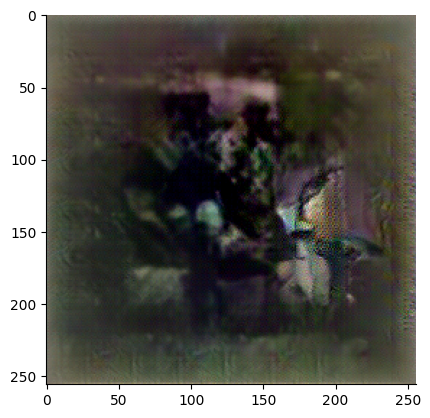

In [5]:
img_opt = G.visualize(new_codes)
plt.imshow(ToPILImage()(img_opt[2]))

In [6]:
for z_code, z_opt_file in zip(z_opts, z_opt_files_name):
    # let perturb the norm of the code
    code_norm = np.linalg.norm(z_code)
    print(f"orginal norm: {code_norm}")

orginal norm: 905.0708618164062
orginal norm: 626.4993896484375
orginal norm: 1055.65576171875
orginal norm: 268.2862548828125
orginal norm: 921.9624633789062
orginal norm: 1007.3638305664062
orginal norm: 270.2415771484375
orginal norm: 1032.589599609375
orginal norm: 329.1556091308594
